In [1]:
from pathlib import Path
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from scipy.stats import shapiro, ttest_rel, wilcoxon, ttest_1samp
import statsmodels.api as sm

from scripts.get_paths import get_path
from scripts.agreement import find_series, compute_series_agreement, compute_series_agreement_3_a_plus_2b

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
paths = get_path()
df = pd.read_csv(paths.features_2 / "extracted_features.csv", index_col=False)
df = df[df['NT']==1] # all analyses for validation only on non SAD diagnosed

### Inter rate agreement between human annotators

In [3]:
# gaze and smile agreement
# Instance level
comparisons = [
    ("gaze_fd", "gaze_vp"),
    ("smile_fd", "smile_vp"),
]

for annotator_1, annotator_2 in comparisons:
    behavior = annotator_1.split("_")[0]  # 'gaze' or 'smile'
    
    agreement_score = compute_series_agreement(
        df,
        behavior,
        annotator_1=annotator_1,
        annotator_2=annotator_2
    )

    percentage = round(agreement_score['agreement_score'] * 100)
    agreed = agreement_score['agreed_series_count']
    total_1 = agreement_score['series_1_count']
    total_2 = agreement_score['series_2_count']

    print(
        f"For {behavior} behavior, annotator 1 and annotator 2 have {percentage}% agreement. "
    )


For gaze behavior, annotator 1 and annotator 2 have 94% agreement. 
For smile behavior, annotator 1 and annotator 2 have 88% agreement. 


In [4]:
# frame level - Cohen's Kappa
comparisons = [
    ("gaze_fd", "gaze_vp"),
    ("smile_fd", "smile_vp"),
]

results = []

for a1, a2 in comparisons:
    df_pair = df[[a1, a2]].dropna()
    kappa = cohen_kappa_score(df_pair[a1], df_pair[a2])
    results.append({"annotator_1": a1, "annotator_2": a2, "cohen_kappa": kappa})

kappa_df = pd.DataFrame(results)
print(kappa_df)


  annotator_1 annotator_2  cohen_kappa
0     gaze_fd     gaze_vp     0.837789
1    smile_fd    smile_vp     0.462921


In [5]:
# nod agreement - only instance level and majority agreemnt
nod_score = compute_series_agreement_3_a_plus_2b(
    df,
    "nod",
    annotator_1="nod_vp",
    annotator_2="nod_fd",
    annotator_3="nod_lk"
)

percentage = round(nod_score['agreement_score'] * 100)
print(
    f"For nod behavior, annotators 1, 2, and 3 have {percentage}% agreement. "
)


For nod behavior, annotators 1, 2, and 3 have 78% agreement. 


### Instance and Frame counts

In [6]:
# Instance counts
participant_ids = df['participant_id'].unique()
all_counts_instances = {}  # use a dict to store annotator statistics

for annotator in ['gaze_fd', 'gaze_vp', 'gaze_openface', 'gaze_pyafar', 
                  'smile_fd', 'smile_vp', 'smile_openface', 'smile_pyafar',
                  'nod_fd', 'nod_vp','nod_lk', 'nod_openface', 'nod_pyafar']:
    results = []

    for pid in participant_ids:
        df_part = df[df['participant_id'] == pid]
        # Count the number of frames where value is 1
        num_instances = len(find_series(df_part, annotator))
        results.append({'participant_id': pid, 'num_instances': num_instances})

    # Convert to DataFrame
    instances_df = pd.DataFrame(results)

    # Compute mean and std
    mean, std = instances_df['num_instances'].mean(), instances_df['num_instances'].std()

    # Store in dictionary
    all_counts_instances[annotator] = {'mean': f"{mean:.2f}", 'std': f"{std:.2f}"}

all_counts_instances

{'gaze_fd': {'mean': '14.81', 'std': '7.71'},
 'gaze_vp': {'mean': '16.43', 'std': '6.52'},
 'gaze_openface': {'mean': '62.43', 'std': '40.95'},
 'gaze_pyafar': {'mean': '70.95', 'std': '35.60'},
 'smile_fd': {'mean': '3.43', 'std': '2.48'},
 'smile_vp': {'mean': '3.38', 'std': '2.65'},
 'smile_openface': {'mean': '28.00', 'std': '17.93'},
 'smile_pyafar': {'mean': '100.19', 'std': '124.03'},
 'nod_fd': {'mean': '1.05', 'std': '1.36'},
 'nod_vp': {'mean': '2.62', 'std': '1.86'},
 'nod_lk': {'mean': '3.52', 'std': '3.31'},
 'nod_openface': {'mean': '1.62', 'std': '2.48'},
 'nod_pyafar': {'mean': '1.81', 'std': '1.81'}}

In [7]:
## statistical comparison of instance counts per participant between human and computational annotators
annotators = ['gaze_fd', 'gaze_vp', 'gaze_openface', 'gaze_pyafar',
              'smile_fd', 'smile_vp', 'smile_openface', 'smile_pyafar',
              'nod_fd', 'nod_vp','nod_lk', 'nod_openface', 'nod_pyafar']

# Build per-participant counts DataFrame
all_counts = []
for pid in participant_ids:
    df_part = df[df['participant_id'] == pid]
    row = {'participant_id': pid}
    for annotator in annotators:
        row[annotator] = len(find_series(df_part, annotator))
    all_counts.append(row)

counts_df = pd.DataFrame(all_counts)

# Define comparisons: human vs computational
comparisons = [
    ("gaze_fd", "gaze_openface"),
    ("gaze_vp", "gaze_openface"),
    ("gaze_fd", "gaze_pyafar"),
    ("gaze_vp", "gaze_pyafar"),
    ("smile_fd", "smile_openface"),
    ("smile_vp", "smile_openface"),
    ("smile_fd", "smile_pyafar"),
    ("smile_vp", "smile_pyafar"),
    ("nod_fd", "nod_openface"),
    ("nod_fd", "nod_pyafar"),
    ("nod_vp", "nod_openface"),
    ("nod_vp", "nod_pyafar"),
    ("nod_lk", "nod_openface"),
    ("nod_lk", "nod_pyafar"),
]

# Run paired t-tests for each comparison
for human, comp in comparisons:
    t_stat, p_val = ttest_rel(counts_df[comp], counts_df[human])
    mean_h, std_h = counts_df[human].mean(), counts_df[human].std()
    mean_c, std_c = counts_df[comp].mean(), counts_df[comp].std()

    print(f"{human} vs {comp}:")
    print(f"  {human}: {mean_h:.2f} ± {std_h:.2f}")
    print(f"  {comp}: {mean_c:.2f} ± {std_c:.2f}")
    print(f"  t = {t_stat:.2f}, p = {p_val:.4f}\n")


gaze_fd vs gaze_openface:
  gaze_fd: 14.81 ± 7.71
  gaze_openface: 62.43 ± 40.95
  t = 5.09, p = 0.0001

gaze_vp vs gaze_openface:
  gaze_vp: 16.43 ± 6.52
  gaze_openface: 62.43 ± 40.95
  t = 5.00, p = 0.0001

gaze_fd vs gaze_pyafar:
  gaze_fd: 14.81 ± 7.71
  gaze_pyafar: 70.95 ± 35.60
  t = 6.99, p = 0.0000

gaze_vp vs gaze_pyafar:
  gaze_vp: 16.43 ± 6.52
  gaze_pyafar: 70.95 ± 35.60
  t = 6.84, p = 0.0000

smile_fd vs smile_openface:
  smile_fd: 3.43 ± 2.48
  smile_openface: 28.00 ± 17.93
  t = 6.68, p = 0.0000

smile_vp vs smile_openface:
  smile_vp: 3.38 ± 2.65
  smile_openface: 28.00 ± 17.93
  t = 6.61, p = 0.0000

smile_fd vs smile_pyafar:
  smile_fd: 3.43 ± 2.48
  smile_pyafar: 100.19 ± 124.03
  t = 3.60, p = 0.0018

smile_vp vs smile_pyafar:
  smile_vp: 3.38 ± 2.65
  smile_pyafar: 100.19 ± 124.03
  t = 3.60, p = 0.0018

nod_fd vs nod_openface:
  nod_fd: 1.05 ± 1.36
  nod_openface: 1.62 ± 2.48
  t = 0.97, p = 0.3459

nod_fd vs nod_pyafar:
  nod_fd: 1.05 ± 1.36
  nod_pyafar: 1.81

In [8]:
# Frame counts
all_counts_frames = {}  # use a dict to store annotator statistics

for annotator in ['gaze_fd', 'gaze_vp', 'gaze_openface', 'gaze_pyafar', 
                  'smile_fd', 'smile_vp', 'smile_openface', 'smile_pyafar',
                  'nod_fd', 'nod_vp','nod_lk', 'nod_openface', 'nod_pyafar']:
    results = []

    for pid in participant_ids:
        df_part = df[df['participant_id'] == pid]
        # Count the number of frames where value is 1
        num_instances = (df_part[annotator] == 1).sum()
        results.append({'participant_id': pid, 'num_instances': num_instances})

    # Convert to DataFrame
    instances_df = pd.DataFrame(results)

    # Compute mean and std
    mean, std = instances_df['num_instances'].mean(), instances_df['num_instances'].std()

    # Store in dictionary
    all_counts_frames[annotator] = {'mean': f"{mean:.2f}", 'std': f"{std:.2f}"}

all_counts_frames


{'gaze_fd': {'mean': '687.76', 'std': '346.21'},
 'gaze_vp': {'mean': '742.86', 'std': '399.13'},
 'gaze_openface': {'mean': '1079.71', 'std': '880.41'},
 'gaze_pyafar': {'mean': '909.48', 'std': '567.33'},
 'smile_fd': {'mean': '216.57', 'std': '241.77'},
 'smile_vp': {'mean': '194.48', 'std': '167.39'},
 'smile_openface': {'mean': '1763.33', 'std': '1488.81'},
 'smile_pyafar': {'mean': '422.24', 'std': '703.78'},
 'nod_fd': {'mean': '23.71', 'std': '30.20'},
 'nod_vp': {'mean': '90.29', 'std': '105.39'},
 'nod_lk': {'mean': '102.62', 'std': '94.43'},
 'nod_openface': {'mean': '56.05', 'std': '75.59'},
 'nod_pyafar': {'mean': '64.52', 'std': '71.27'}}

In [9]:
## statistical comparison of frame counts per participant between human and computational annotators
participant_ids = df['participant_id'].unique()
annotators = ['gaze_fd', 'gaze_vp', 'gaze_openface', 'gaze_pyafar', 
                  'smile_fd', 'smile_vp', 'smile_openface', 'smile_pyafar',
                  'nod_fd', 'nod_vp','nod_lk', 'nod_openface', 'nod_pyafar']

# Build per-participant counts DataFrame
all_counts = []
for pid in participant_ids:
    df_part = df[df['participant_id'] == pid]
    row = {'participant_id': pid}
    for annotator in annotators:
        row[annotator] = (df_part[annotator] == 1).sum()
    all_counts.append(row)

counts_df = pd.DataFrame(all_counts)

# Define comparisons: human vs computational
comparisons = [
    ("gaze_fd", "gaze_vp"),
    ("gaze_fd", "gaze_openface"),
    ("gaze_vp", "gaze_openface"),
    ("gaze_fd", "gaze_pyafar"),
    ("gaze_vp", "gaze_pyafar"),
    ("smile_fd", "smile_vp"),
    ("smile_fd", "smile_openface"),
    ("smile_vp", "smile_openface"),
    ("smile_fd", "smile_pyafar"),
    ("smile_vp", "smile_pyafar"),
    ("nod_fd", "nod_openface"),
    ("nod_fd", "nod_pyafar"),
    ("nod_vp", "nod_openface"),
    ("nod_vp", "nod_pyafar"),
    ("nod_lk", "nod_openface"),
    ("nod_lk", "nod_pyafar"),
]

# Run paired t-tests for each comparison
for human, comp in comparisons:
    t_stat, p_val = ttest_rel(counts_df[comp], counts_df[human])
    mean_h, std_h = counts_df[human].mean(), counts_df[human].std()
    mean_c, std_c = counts_df[comp].mean(), counts_df[comp].std()

    print(f"{human} vs {comp}:")
    print(f"  {human}: {mean_h:.2f} ± {std_h:.2f}")
    print(f"  {comp}: {mean_c:.2f} ± {std_c:.2f}")
    print(f"  t = {t_stat:.2f}, p = {p_val:.4f}\n")


gaze_fd vs gaze_vp:
  gaze_fd: 687.76 ± 346.21
  gaze_vp: 742.86 ± 399.13
  t = 0.93, p = 0.3622

gaze_fd vs gaze_openface:
  gaze_fd: 687.76 ± 346.21
  gaze_openface: 1079.71 ± 880.41
  t = 1.88, p = 0.0750

gaze_vp vs gaze_openface:
  gaze_vp: 742.86 ± 399.13
  gaze_openface: 1079.71 ± 880.41
  t = 1.68, p = 0.1091

gaze_fd vs gaze_pyafar:
  gaze_fd: 687.76 ± 346.21
  gaze_pyafar: 909.48 ± 567.33
  t = 1.89, p = 0.0731

gaze_vp vs gaze_pyafar:
  gaze_vp: 742.86 ± 399.13
  gaze_pyafar: 909.48 ± 567.33
  t = 1.35, p = 0.1909

smile_fd vs smile_vp:
  smile_fd: 216.57 ± 241.77
  smile_vp: 194.48 ± 167.39
  t = -0.52, p = 0.6059

smile_fd vs smile_openface:
  smile_fd: 216.57 ± 241.77
  smile_openface: 1763.33 ± 1488.81
  t = 5.17, p = 0.0000

smile_vp vs smile_openface:
  smile_vp: 194.48 ± 167.39
  smile_openface: 1763.33 ± 1488.81
  t = 5.26, p = 0.0000

smile_fd vs smile_pyafar:
  smile_fd: 216.57 ± 241.77
  smile_pyafar: 422.24 ± 703.78
  t = 1.40, p = 0.1759

smile_vp vs smile_pyafa

### Instance level agreement between annotators and computational methods

In [10]:
comparisons = [
    ("gaze_fd", "gaze_openface"),
    ("gaze_vp", "gaze_openface"),
    ("gaze_fd", "gaze_pyafar"),
    ("gaze_vp", "gaze_pyafar"),
    ("smile_fd", "smile_openface"),
    ("smile_vp", "smile_openface"),
    ("smile_fd", "smile_pyafar"),
    ("smile_vp", "smile_pyafar"),
    ("nod_fd", "nod_openface"),
    ("nod_fd", "nod_pyafar"),
    ("nod_vp", "nod_openface"),
    ("nod_vp", "nod_pyafar"),
    ("nod_lk", "nod_openface"),
    ("nod_lk", "nod_pyafar"),
]

for annotator_1, annotator_2 in comparisons:
    agreement_score = compute_series_agreement(
        df,
        annotator_1.split("_")[0],   
        annotator_1=annotator_1,
        annotator_2=annotator_2
    )
    print(f"{annotator_1} vs {annotator_2}: {round(agreement_score['agreement_score']*100), agreement_score['agreed_series_count'], agreement_score['series_1_count'], agreement_score['series_2_count']}")


gaze_fd vs gaze_openface: (38, 311, 311, 1311)
gaze_vp vs gaze_openface: (42, 344, 345, 1311)
gaze_fd vs gaze_pyafar: (35, 311, 311, 1490)
gaze_vp vs gaze_pyafar: (38, 345, 345, 1490)
smile_fd vs smile_openface: (22, 72, 72, 588)
smile_vp vs smile_openface: (22, 71, 71, 588)
smile_fd vs smile_pyafar: (7, 72, 72, 2104)
smile_vp vs smile_pyafar: (6, 70, 71, 2104)
nod_fd vs nod_openface: (32, 9, 22, 34)
nod_fd vs nod_pyafar: (37, 11, 22, 38)
nod_vp vs nod_openface: (63, 28, 55, 34)
nod_vp vs nod_pyafar: (60, 28, 55, 38)
nod_lk vs nod_openface: (57, 31, 74, 34)
nod_lk vs nod_pyafar: (59, 33, 74, 38)


### Frame level agreement between annotators and computational methods

In [11]:
# Define comparisons: human vs computational (and human-human too if you like)
comparisons = [
    ("gaze_fd", "gaze_openface"),
    ("gaze_vp", "gaze_openface"),
    ("gaze_fd", "gaze_pyafar"),
    ("gaze_vp", "gaze_pyafar"),
    ("smile_fd", "smile_openface"),
    ("smile_vp", "smile_openface"),
    ("smile_fd", "smile_pyafar"),
    ("smile_vp", "smile_pyafar"),
]

results = []

for a1, a2 in comparisons:
    df_pair = df[[a1, a2]].dropna()
    kappa = cohen_kappa_score(df_pair[a1], df_pair[a2])
    results.append({"annotator_1": a1, "annotator_2": a2, "cohen_kappa": kappa})

kappa_df = pd.DataFrame(results)
print(kappa_df)


  annotator_1     annotator_2  cohen_kappa
0     gaze_fd   gaze_openface     0.285027
1     gaze_vp   gaze_openface     0.294745
2     gaze_fd     gaze_pyafar     0.553346
3     gaze_vp     gaze_pyafar     0.567157
4    smile_fd  smile_openface     0.142183
5    smile_vp  smile_openface     0.119491
6    smile_fd    smile_pyafar     0.235840
7    smile_vp    smile_pyafar     0.212850


## Part and speaker wise comparisions

In [12]:
results = []
annotator_combinations = {
    'gaze': ['gaze_agreed', 'gaze_pyafar','gaze_openface'],
    'smile': ['smile_agreed', 'smile_pyafar','smile_openface'],
    'nod' : ['nod_agreed', 'nod_pyafar','nod_openface']
}
for (participant_id, part, speaker), group in df.groupby(['participant_id', 'part', 'speaker']):
  
    total_frames_in_part = len(group)

    for behavior, annotators in annotator_combinations.items():
        for annotator in annotators:
            # Total frames where this specific annotation occurs
            frames = group[annotator].sum()
            normalized_frames = 100 * frames / total_frames_in_part if total_frames_in_part > 0 else np.nan

            instance_count = len(find_series(group, annotator))
            results.append({
                'participant_id': participant_id,
                'part': part,
                'speaker': speaker,
                'behavior': behavior,
                'annotator_type': annotator,   # e.g. gaze_agreed / gaze_occurance
                'annotated_frames': frames,
                'normalized_agreed_frames': normalized_frames,
                'instance_count': instance_count,
                'total_frames_in_part': total_frames_in_part
            })

# Convert to a summary DataFrame
summary_df = pd.DataFrame(results)

/tmp/ipykernel_3981046/3425412772.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_left.set_xticklabels([
/tmp/ipykernel_3981046/3425412772.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_xticklabels([
/tmp/ipykernel_3981046/3425412772.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_left.set_xticklabels([
/tmp/ipykernel_3981046/3425412772.py:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_xticklabels([
/tmp/ipykernel_3981046/3425412772.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_left.set_xticklabels([
/tmp/ipyker

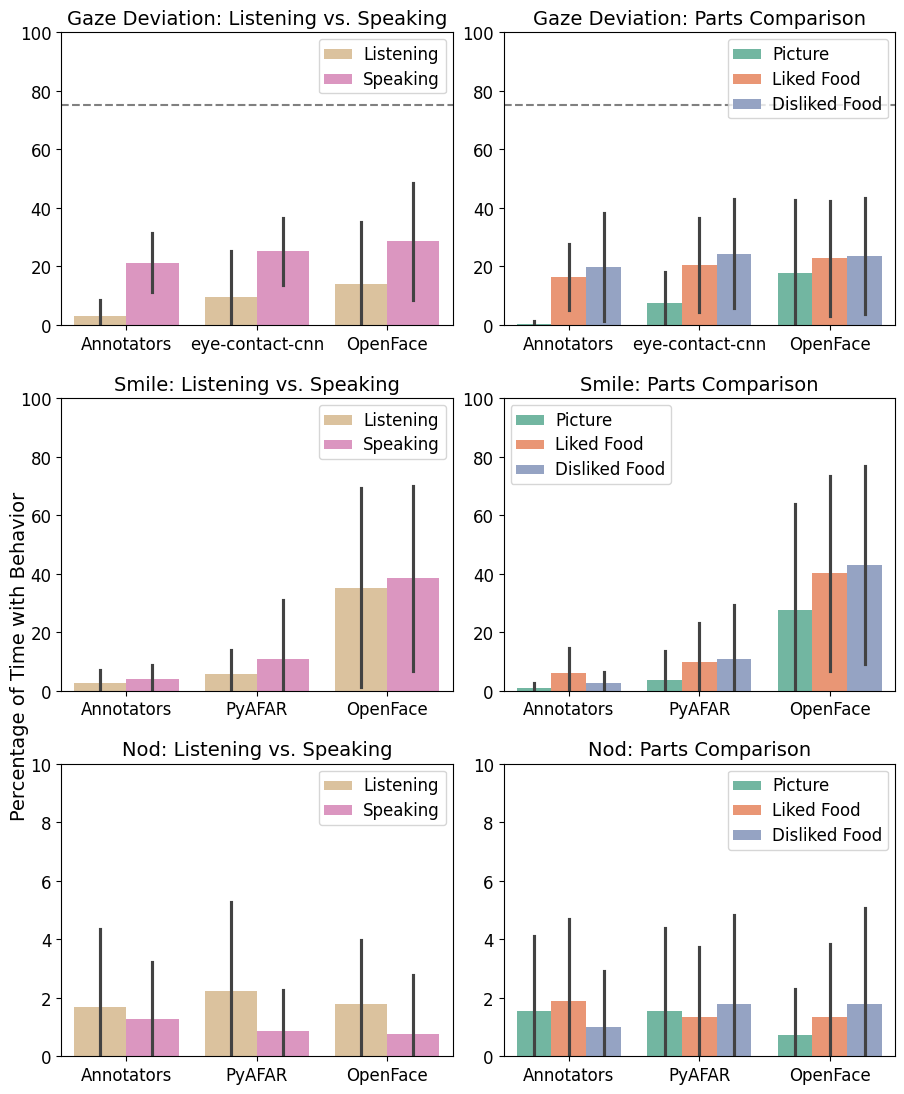

In [13]:
selected_behaviors = ["gaze_agreed", "smile_agreed", "nod_agreed"]
selected_behaviors_pyafar = ["gaze_pyafar", "smile_pyafar", "nod_pyafar"]
selected_behaviors_openface = ["gaze_openface", "smile_openface", "nod_openface"]

part_order = ["picture", "liked food", "disliked food"]
palette = sns.color_palette("Set2")

speaker_labels = {"actress": "Listening", "participant": "Speaking"}
part_labels = {"picture": "Picture", "liked food": "Liked Food", "disliked food": "Disliked Food"}

measure_labels_gaze = {"Annotators": "Annotators", "Pyafar": "eye-contact-cnn", "OpenFace": "OpenFace"}
measure_labels_smile = {"Annotators": "Annotators", "Pyafar": "PyAFAR", "OpenFace": "OpenFace"}
measure_labels_nod  = {"Annotators": "Annotators", "Pyafar": "PyAFAR", "OpenFace": "OpenFace"}  # change if you want

titles = [
    "Gaze Deviation: Listening vs. Speaking",
    "Gaze Deviation: Parts Comparison",
    "Smile: Listening vs. Speaking",
    "Smile: Parts Comparison",
    "Nod: Listening vs. Speaking",
    "Nod: Parts Comparison"
]
# Speaker colors (left column)
speaker_palette = {
    "actress": "#e5c494",      # light orange (Listening)
    "participant": "#e78ac3"  # dark orange (Speaking)
}

# Part palette (three greens)
part_palette = {
    "picture": "#66c2a5",      # light green
    "liked food": "#fc8d62",   # medium green
    "disliked food": "#8da0cb" # dark green
}
# ---- 3 rows x 2 cols ----
fig, axes = plt.subplots(3, 2, figsize=(9, 11))

for i, behavior in enumerate(selected_behaviors):
    behavior_pyafar = selected_behaviors_pyafar[i]
    behavior_openface = selected_behaviors_openface[i]

    # pick measure label mapping per row
    if i == 0:
        measure_labels = measure_labels_gaze
    elif i == 1:
        measure_labels = measure_labels_smile
    else:
        measure_labels = measure_labels_nod

    # y-limit: nod row clipped to 10, others 0-100
    y_max = 10 if i == 2 else 100

    left_data_annotation = summary_df[summary_df['annotator_type'] == behavior]
    left_data_pyafar = summary_df[summary_df['annotator_type'] == behavior_pyafar]
    left_data_openface = summary_df[summary_df['annotator_type'] == behavior_openface]

    # ---------------- Left plot: speaker ----------------
    speaker_comparison_annotation = left_data_annotation.groupby(
        ['participant_id', 'speaker'], as_index=False
    ).agg({'normalized_agreed_frames': 'mean'})
    speaker_comparison_pyafar = left_data_pyafar.groupby(
        ['participant_id', 'speaker'], as_index=False
    ).agg({'normalized_agreed_frames': 'mean'})
    speaker_comparison_openface = left_data_openface.groupby(
        ['participant_id', 'speaker'], as_index=False
    ).agg({'normalized_agreed_frames': 'mean'})

    speaker_comparison_annotation['measure'] = 'Annotators'
    speaker_comparison_pyafar['measure'] = 'Pyafar'
    speaker_comparison_openface['measure'] = 'OpenFace'

    combined_speaker_data = pd.concat(
        [speaker_comparison_annotation, speaker_comparison_pyafar, speaker_comparison_openface],
        ignore_index=True
    )

    ax_left = axes[i, 0]
    sns.barplot(
        data=combined_speaker_data,
        x="measure", y="normalized_agreed_frames", hue="speaker",
        ax=ax_left, dodge=True, errorbar="sd", palette= speaker_palette
    )
    ax_left.set_title(titles[i*2])
    ax_left.set_ylim(0, y_max)
    ax_left.set_ylabel("")
    ax_left.set_xlabel("")

    # rename x tick labels (Pyafar -> eye-contact-cnn / PyAFAR)
    ax_left.set_xticklabels([
        measure_labels.get(lbl.get_text(), lbl.get_text())
        for lbl in ax_left.get_xticklabels()
    ])

    # legend labels for speaker
    handles, labels = ax_left.get_legend_handles_labels()
    ax_left.legend(handles, [speaker_labels.get(l, l) for l in labels], title="")

    # keep your 75% line only for gaze if you want
    if i == 0:
        ax_left.axhline(75, color='gray', linestyle='--')

    # ---------------- Right plot: part ----------------
    part_comparison_annotation = left_data_annotation.groupby(
        ['participant_id', 'part'], as_index=False
    ).agg({'normalized_agreed_frames': 'mean'})
    part_comparison_pyafar = left_data_pyafar.groupby(
        ['participant_id', 'part'], as_index=False
    ).agg({'normalized_agreed_frames': 'mean'})
    part_comparison_openface = left_data_openface.groupby(
        ['participant_id', 'part'], as_index=False
    ).agg({'normalized_agreed_frames': 'mean'})

    part_comparison_annotation['measure'] = 'Annotators'
    part_comparison_pyafar['measure'] = 'Pyafar'
    part_comparison_openface['measure'] = 'OpenFace'

    combined_part_data = pd.concat(
        [part_comparison_annotation, part_comparison_pyafar, part_comparison_openface],
        ignore_index=True
    )

    ax_right = axes[i, 1]
    sns.barplot(
        data=combined_part_data,
        x="measure", y="normalized_agreed_frames", hue="part",
        ax=ax_right, dodge=True, errorbar="sd", hue_order=part_order, palette=part_palette
    )
    ax_right.set_title(titles[i*2 + 1])
    ax_right.set_ylim(0, y_max)
    ax_right.set_ylabel("")
    ax_right.set_xlabel("")

    ax_right.set_xticklabels([
        measure_labels.get(lbl.get_text(), lbl.get_text())
        for lbl in ax_right.get_xticklabels()
    ])
    #ax_left.tick_params(axis='x', labelsize=14)
    #ax_right.tick_params(axis='x', labelsize=14)

    handles, labels = ax_right.get_legend_handles_labels()
    ax_right.legend(handles, [part_labels.get(l, l) for l in labels], title="")

    if i == 0:
        ax_right.axhline(75, color='gray', linestyle='--')

# Shared y-axis label
#fig.text(0.06, 0.5, 'Percentage of Time with Behavior', va='center', rotation='vertical', fontsize=14)
fig.text(0.0, 0.4, 'Percentage of Time with Behavior', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
# --- font sizes ---
TICK_SIZE = 12
LABEL_SIZE = 12
LEGEND_SIZE = 12
TITLE_SIZE = 14

for ax_row in axes:
    for ax in ax_row:
        # tick labels
        ax.tick_params(axis='both', labelsize=TICK_SIZE)

        # axis labels (even if empty, keeps consistency)
        ax.xaxis.label.set_size(LABEL_SIZE)
        ax.yaxis.label.set_size(LABEL_SIZE)

        # title
        ax.title.set_size(TITLE_SIZE)

        # legend
        legend = ax.get_legend()
        if legend is not None:
            for text in legend.get_texts():
                text.set_fontsize(LEGEND_SIZE)

plt.show()


### Statistical tests

##### One-Sample Test for gaze deviation compared against 75%

In [14]:
behaviors = summary_df['annotator_type'].unique()
# Collect descriptives across all parts (per participant first)
desc_stats_all = []

for behavior in behaviors:
    # Filter for the behavior
    temp_df = summary_df[summary_df['annotator_type'] == behavior]

    # Aggregate across all parts for each participant
    participant_means = temp_df.groupby('participant_id')['normalized_agreed_frames'].mean()

    # Compute descriptives on participant-level distribution
    desc = participant_means.describe()

    desc_stats_all.append({
        'annotator_type': behavior,
        'mean': desc['mean'],
        'median': participant_means.median(),
        'std': desc['std'],
        'min': desc['min'],
        'max': desc['max'],
        'n': desc['count']
    })

# Create DataFrame
desc_stats_all = pd.DataFrame(desc_stats_all)
display(desc_stats_all)
for annotator in ['gaze_agreed','gaze_openface','gaze_pyafar']:

    gaze_df = summary_df[summary_df['annotator_type'] == annotator]

    # Aggregate by participant (averaging across behaviors and parts if needed)
    gaze_grouped = gaze_df.groupby('participant_id')['normalized_agreed_frames'].mean().reset_index()

    # Extract the values for testing
    participant_vals = gaze_grouped['normalized_agreed_frames']

    print(f"\n===== Overall One-Sample Test for {annotator} against 75% =====")

    # Shapiro-Wilk normality check
    stat, p_shapiro = shapiro(participant_vals)
    print(f"Shapiro-Wilk p-value for normality: {p_shapiro:.4f}")

    if p_shapiro > 0.05:
        # Normal distribution -> one-sample t-test
        t_stat, p_ttest = ttest_1samp(participant_vals, 0.75)
        print(f"One-sample t-test (against 0.75): t = {t_stat:.4f}, p = {p_ttest:.4f}")
    else:
        # Non-normal distribution -> Wilcoxon signed-rank test
        if (participant_vals != 0.75).any():
            w_stat, p_wilcoxon = wilcoxon(participant_vals - 0.75)
            print(f"Wilcoxon signed-rank test (against 0.75): W = {w_stat}, p = {p_wilcoxon:.4f}")
        else:
            print("All participant values are 75%. Wilcoxon not applicable.")


,annotator_type,mean,median,std,min,max,n
0,gaze_agreed,12.244691,10.696092,6.496442,2.785816,27.390922,21.0
1,gaze_pyafar,17.373617,14.267637,12.421482,5.652029,60.046980,21.0
2,gaze_openface,21.313263,16.312643,18.916230,0.170590,77.010553,21.0
3,smile_agreed,3.185417,2.133733,3.300329,0.000000,9.674897,21.0
4,smile_pyafar,8.150622,2.449752,13.137646,0.000000,54.893084,21.0
5,smile_openface,36.831340,36.773622,32.021145,0.000000,95.770343,21.0
6,nod_agreed,1.478702,1.312022,1.575740,0.000000,5.141305,21.0
7,nod_pyafar,1.550487,1.536885,1.690574,0.000000,5.352437,21.0
8,nod_openface,1.284200,0.776398,1.541847,0.000000,6.049140,21.0



===== Overall One-Sample Test for gaze_agreed against 75% =====
Shapiro-Wilk p-value for normality: 0.3846
One-sample t-test (against 0.75): t = 8.1083, p = 0.0000

===== Overall One-Sample Test for gaze_openface against 75% =====
Shapiro-Wilk p-value for normality: 0.0133
Wilcoxon signed-rank test (against 0.75): W = 3.0, p = 0.0000

===== Overall One-Sample Test for gaze_pyafar against 75% =====
Shapiro-Wilk p-value for normality: 0.0001
Wilcoxon signed-rank test (against 0.75): W = 0.0, p = 0.0000


##### Comparision between listening and speaking

In [15]:
# Set up list to collect descriptive statistics
desc_stats_speaker = []

for behavior in behaviors:
    # Filter for the behavior
    temp_df = summary_df[summary_df['annotator_type'] == behavior]

    # Pivot to get both speakers for each participant and part
    pivot = temp_df.pivot_table(
        index=['participant_id'],
        columns='speaker',
        values='normalized_agreed_frames'
    ).reset_index()

    # Drop NaNs
    comparison_df = pivot.dropna(subset=['actress', 'participant'])
    # Compute descriptives for actress
    desc_actress = comparison_df['actress'].describe()
    # Compute descriptives for participant
    desc_participant = comparison_df['participant'].describe()

    # Append results
    desc_stats_speaker.append({
        'annotator_type': behavior,
        'group': 'actress',
        'mean': desc_actress['mean'],
        'median': comparison_df['actress'].median(),
        'std': desc_actress['std'],
        'min': desc_actress['min'],
        'max': desc_actress['max'],
        'n': desc_actress['count']
    })

    desc_stats_speaker.append({
        'annotator_type': behavior,
        'group': 'participant',
        'mean': desc_participant['mean'],
        'median': comparison_df['participant'].median(),
        'std': desc_participant['std'],
        'min': desc_participant['min'],
        'max': desc_participant['max'],
        'n': desc_participant['count']
    })

# Create DataFrame for speaker comparison descriptives
desc_df_speaker = pd.DataFrame(desc_stats_speaker)
display(desc_df_speaker)
for behavior in behaviors:
    print(f"\n===== comparision between listening and speaking for - {behavior} =====")

    # Pivot the table to have 'speaker' as columns
    pivot = summary_df[summary_df['annotator_type'] == behavior].pivot_table(
        values='normalized_agreed_frames',
        index=['participant_id'],
        columns='speaker'
    ).reset_index()

    # Drop any participants where data is missing for either speaker
    comparison_df = pivot.dropna(subset=['actress', 'participant'])

    # Calculate difference (participant - actress)
    diff = comparison_df['participant'] - comparison_df['actress']

    # Shapiro-Wilk normality test on the differences
    stat, p_shapiro = shapiro(diff)
    print(f"Shapiro-Wilk test p-value for normality: {p_shapiro:.4f}")

    if p_shapiro > 0.05:
        # Normal distribution -> Paired t-test
        t_stat, p_ttest = ttest_rel(comparison_df['participant'], comparison_df['actress'])
        print(f"Paired t-test: t = {t_stat:.4f}, p = {p_ttest:.4f}")
    else:
        # Non-normal -> Wilcoxon signed-rank test
        w_stat, p_wilcoxon = wilcoxon(comparison_df['participant'], comparison_df['actress'])
        print(f"Wilcoxon signed-rank test: W = {w_stat}, p = {p_wilcoxon:.4f}")


,annotator_type,group,mean,median,std,min,max,n
0,gaze_agreed,actress,3.182020,1.268912,5.475590,0.000000,24.001996,21.0
1,gaze_agreed,participant,21.307363,21.063395,10.067118,3.781346,39.100162,21.0
2,gaze_pyafar,actress,9.644286,6.399865,15.453916,0.099800,69.474815,21.0
3,gaze_pyafar,participant,25.102947,23.908367,11.472112,10.119067,50.619145,21.0
4,gaze_openface,actress,13.981270,5.712407,21.213383,0.000000,84.970798,21.0
5,gaze_openface,participant,28.645255,28.443799,20.002354,0.000000,69.050309,21.0
6,smile_agreed,actress,2.514723,0.000000,4.385173,0.000000,16.691069,21.0
7,smile_agreed,participant,3.856111,1.467076,4.900606,0.000000,14.225342,21.0
8,smile_pyafar,actress,5.527275,2.000876,8.489420,0.000000,31.939465,21.0
9,smile_pyafar,participant,10.773969,2.698908,20.330036,0.000000,90.553351,21.0



===== comparision between listening and speaking for - gaze_agreed =====
Shapiro-Wilk test p-value for normality: 0.4546
Paired t-test: t = 8.5742, p = 0.0000

===== comparision between listening and speaking for - gaze_pyafar =====
Shapiro-Wilk test p-value for normality: 0.0299
Wilcoxon signed-rank test: W = 14.0, p = 0.0001

===== comparision between listening and speaking for - gaze_openface =====
Shapiro-Wilk test p-value for normality: 0.3309
Paired t-test: t = 4.0979, p = 0.0006

===== comparision between listening and speaking for - smile_agreed =====
Shapiro-Wilk test p-value for normality: 0.0579
Paired t-test: t = 0.9383, p = 0.3593

===== comparision between listening and speaking for - smile_pyafar =====
Shapiro-Wilk test p-value for normality: 0.0000
Wilcoxon signed-rank test: W = 43.0, p = 0.0642

===== comparision between listening and speaking for - smile_openface =====
Shapiro-Wilk test p-value for normality: 0.7561
Paired t-test: t = 1.0048, p = 0.3270

===== compar

##### Comparision between picture, liked, disliked parts

In [16]:
# Set up list to collect descriptive statistics
desc_stats_part = []

for behavior in behaviors:
    # Filter for the behavior
    temp_df = summary_df[summary_df['annotator_type'] == behavior]

    # Pivot to get both speakers for each participant and part
    pivot = temp_df.pivot_table(
        index=['participant_id'],
        columns='part',
        values='normalized_agreed_frames'
    ).reset_index()

    # Drop NaNs
    comparison_df = pivot.dropna(subset=["picture", "liked food", "disliked food"])
    # Compute descriptives for actress
    desc_pic = comparison_df['picture'].describe()
    # Compute descriptives for participant
    desc_liked = comparison_df['liked food'].describe()
    # Compute descriptives for participant
    desc_disliked = comparison_df['disliked food'].describe()

    # Append results
    desc_stats_part.append({
        'annotator_type': behavior,
        'group': 'picture',
        'mean': desc_pic['mean'],
        'median': comparison_df['picture'].median(),
        'std': desc_pic['std'],
        'min': desc_pic['min'],
        'max': desc_pic['max'],
        'n': desc_pic['count']
    })

    desc_stats_part.append({
        'annotator_type': behavior,
        'group': 'liked food',
        'mean': desc_liked['mean'],
        'median': comparison_df['liked food'].median(),
        'std': desc_liked['std'],
        'min': desc_liked['min'],
        'max': desc_liked['max'],
        'n': desc_liked['count']
    })

    desc_stats_part.append({
        'annotator_type': behavior,
        'group': 'disliked food',
        'mean': desc_disliked['mean'],
        'median': comparison_df['disliked food'].median(),
        'std': desc_disliked['std'],
        'min': desc_disliked['min'],
        'max': desc_disliked['max'],
        'n': desc_disliked['count']
    })

# Create DataFrame for speaker comparison descriptives
desc_stats_part = pd.DataFrame(desc_stats_part)
display(desc_stats_part)
for behavior in behaviors:
    print(f"\n===== comparision between picture, liked, disliked parts for - {behavior} =====")

    # Pivot the table to have 'speaker' as columns
    pivot = summary_df[summary_df['annotator_type'] == behavior].pivot_table(
        values='normalized_agreed_frames',
        index=['participant_id'],
        columns='part'
    ).reset_index()

    # Drop any participants where data is missing for either speaker
    comparison_df = pivot.dropna(subset=["picture", "liked food", "disliked food"])

    ######
    print(f"\n comparision between picture and liked food")
    # Calculate difference (participant - actress)
    diff = comparison_df['picture'] - comparison_df['liked food']

    # Shapiro-Wilk normality test on the differences
    stat, p_shapiro = shapiro(diff)
    print(f"Shapiro-Wilk test p-value for normality: {p_shapiro:.4f}")

    if p_shapiro > 0.05:
        # Normal distribution -> Paired t-test
        t_stat, p_ttest = ttest_rel(comparison_df['picture'], comparison_df['liked food'])
        print(f"Paired t-test: t = {t_stat:.4f}, p = {p_ttest:.4f}")
    else:
        # Non-normal -> Wilcoxon signed-rank test
        w_stat, p_wilcoxon = wilcoxon(comparison_df['picture'], comparison_df['liked food'])
        print(f"Wilcoxon signed-rank test: W = {w_stat}, p = {p_wilcoxon:.4f}")

    ######
    print(f"\n comparision between liked food and disliked food")
    # Calculate difference (participant - actress)
    diff = comparison_df['liked food'] - comparison_df['disliked food']

    # Shapiro-Wilk normality test on the differences
    stat, p_shapiro = shapiro(diff)
    print(f"Shapiro-Wilk test p-value for normality: {p_shapiro:.4f}")

    if p_shapiro > 0.05:
        # Normal distribution -> Paired t-test
        t_stat, p_ttest = ttest_rel(comparison_df['liked food'], comparison_df['disliked food'])
        print(f"Paired t-test: t = {t_stat:.4f}, p = {p_ttest:.4f}")
    else:
        # Non-normal -> Wilcoxon signed-rank test
        w_stat, p_wilcoxon = wilcoxon(comparison_df['liked food'], comparison_df['disliked food'])
        print(f"Wilcoxon signed-rank test: W = {w_stat}, p = {p_wilcoxon:.4f}")

    ######
    print(f"\n comparision between disliked food and picture")
    # Calculate difference (participant - actress)
    diff = comparison_df['disliked food'] - comparison_df['picture']

    # Shapiro-Wilk normality test on the differences
    stat, p_shapiro = shapiro(diff)
    print(f"Shapiro-Wilk test p-value for normality: {p_shapiro:.4f}")

    if p_shapiro > 0.05:
        # Normal distribution -> Paired t-test
        t_stat, p_ttest = ttest_rel(comparison_df['disliked food'], comparison_df['picture'])
        print(f"Paired t-test: t = {t_stat:.4f}, p = {p_ttest:.4f}")
    else:
        # Non-normal -> Wilcoxon signed-rank test
        w_stat, p_wilcoxon = wilcoxon(comparison_df['disliked food'], comparison_df['picture'])
        print(f"Wilcoxon signed-rank test: W = {w_stat}, p = {p_wilcoxon:.4f}")

,annotator_type,group,mean,median,std,min,max,n
0,gaze_agreed,picture,0.434797,0.000000,1.048369,0.000000,3.624658,21.0
1,gaze_agreed,liked food,16.488142,14.738997,11.329597,0.000000,38.622910,21.0
2,gaze_agreed,disliked food,19.811135,16.754990,18.465489,0.000000,82.172766,21.0
3,gaze_pyafar,picture,7.364451,3.440972,10.545622,0.000000,35.589552,21.0
4,gaze_pyafar,liked food,20.395684,15.447832,16.059288,5.419223,78.311486,21.0
5,gaze_pyafar,disliked food,24.360715,17.716942,18.683555,9.716570,80.297480,21.0
6,gaze_openface,picture,17.696168,9.035688,25.050841,0.000000,100.000000,21.0
7,gaze_openface,liked food,22.720597,22.080996,19.719480,0.511771,90.154781,21.0
8,gaze_openface,disliked food,23.523022,22.304073,19.902246,0.000000,89.134233,21.0
9,smile_agreed,picture,0.913961,0.000000,1.687448,0.000000,4.677060,21.0



===== comparision between picture, liked, disliked parts for - gaze_agreed =====

 comparision between picture and liked food
Shapiro-Wilk test p-value for normality: 0.6268
Paired t-test: t = -6.4503, p = 0.0000

 comparision between liked food and disliked food
Shapiro-Wilk test p-value for normality: 0.0029
Wilcoxon signed-rank test: W = 98.0, p = 0.5621

 comparision between disliked food and picture
Shapiro-Wilk test p-value for normality: 0.0026
Wilcoxon signed-rank test: W = 1.0, p = 0.0002

===== comparision between picture, liked, disliked parts for - gaze_pyafar =====

 comparision between picture and liked food
Shapiro-Wilk test p-value for normality: 0.1315
Paired t-test: t = -3.8696, p = 0.0010

 comparision between liked food and disliked food
Shapiro-Wilk test p-value for normality: 0.0025
Wilcoxon signed-rank test: W = 59.0, p = 0.0502

 comparision between disliked food and picture
Shapiro-Wilk test p-value for normality: 0.0224
Wilcoxon signed-rank test: W = 23.0, p 